In [1]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import tensorflow as tf

2025-07-05 07:55:21.176866: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-05 07:55:21.586790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751702121.765180    3374 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751702121.818764    3374 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-05 07:55:22.188035: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.18.0
Num GPUs Available: 1


In [4]:
pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /root/miniconda3/envs/tf/lib/python3.9/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip show tensorflow-cpu

Note: you may need to restart the kernel to use updated packages.


In [6]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

In [7]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [8]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [9]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [10]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [11]:
X = np.array(X)
y = np.array(y)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [13]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [14]:
X_train_scaled.shape

(2752, 180, 180, 3)

In [15]:
img_height = 180
img_width = 180

In [16]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


/root/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-07-05 07:55:52.905072: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1751702152.905264    3374 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1751702152.906676    3374 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


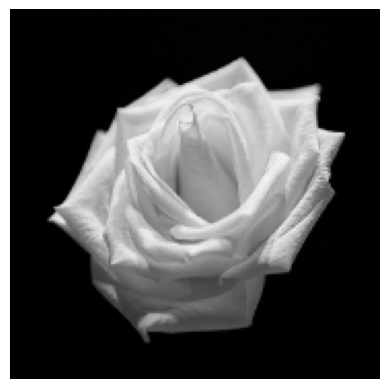

In [17]:
plt.axis('off')
plt.imshow(X[0])

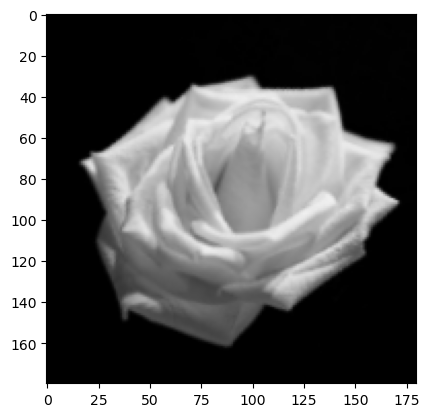

In [18]:
batch_size = 4 # or 16 or 8, depending on your GPU memory
X_batch = X[:batch_size]  # just a smaller chunk
plt.imshow(data_augmentation(X_batch)[0].numpy().astype("uint8"))

In [20]:
num_classes = 5

model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=10, batch_size=16) 

Epoch 1/10


E0000 00:00:1751702225.070503    3374 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1751702226.521683    3465 cuda_dnn.cc:529] Loaded cuDNN version 90300


172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.4175 - loss: 1.3780
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5984 - loss: 1.0469
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6644 - loss: 0.9140
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6742 - loss: 0.8531
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6897 - loss: 0.7878
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6980 - loss: 0.7678
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7303 - loss: 0.7118
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7276 - loss: 0.6870
Epoch 9/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7521 - loss: 0.6387
Epoch 10/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7433 - loss: 0.6360


In [21]:
model.evaluate(X_test_scaled,y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6933 - loss: 0.8524


[0.8040825724601746, 0.7145969271659851]

Needed more computation power so, compromised in 10 epochs, more epochs gave better results  